In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Ready to start!.")

Ready to start!.


In [2]:
finding = "Mass"

In [3]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
positives = df.loc[df["label"]==finding]
positives.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
583,00023075_033.jpg,2992,2991,Mass,239.0,535.0,311.0,600.0,PA
584,00029579_005.jpg,1930,2021,Mass,609.0,189.0,682.0,260.0,PA
585,00013659_019.jpg,2500,2048,Mass,559.0,167.0,661.0,303.0,AP
586,00010815_006.jpg,2842,2991,Mass,311.0,241.0,457.0,497.0,PA
587,00026695_000.jpg,2450,2991,Mass,341.0,197.0,458.0,328.0,PA


In [5]:
negatives = df.loc[df["label"] == "No Finding"]
negatives.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
984,00000002_000.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,PA
985,00000005_000.jpg,2048,2500,No Finding,NaN,NaN,NaN,NaN,PA
986,00000005_001.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
987,00000005_002.jpg,2500,2048,No Finding,NaN,NaN,NaN,NaN,AP
988,00000005_003.jpg,2992,2991,No Finding,NaN,NaN,NaN,NaN,PA


In [6]:
n = len(positives)
print(n)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

85


In [7]:
TRAIN_RATIO = 0.8
TEST_RATIO =0.2
TRAIN_N = int(n * TRAIN_RATIO)
TEST_N = int(n * TEST_RATIO)
print(TRAIN_N, TEST_N)

68 17


In [8]:
print(len(positives))

85


In [9]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

## Data preprocessing

In [10]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive")
os.makedirs(rootdir+finding+"/train/positive")
os.makedirs(rootdir+finding+"/test/negative")
os.makedirs(rootdir+finding+"/train/negative")

In [11]:
for idx, image in positives[:TRAIN_N].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/train/positive/"+ image["filename"]
    shutil.copy(source, dst)

In [12]:
for idx, image in positives[TRAIN_N:].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/test/positive/"+ image["filename"]
    shutil.copy(source, dst)

In [13]:
for idx, image in negatives[:TRAIN_N].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/train/negative/"+ image["filename"]
    shutil.copy(source, dst)

In [14]:
for idx, image in negatives[TRAIN_N:n].iterrows():
    source = rootdir+image["filename"]
    dst = rootdir+finding+"/test/negative/"+ image["filename"]
    shutil.copy(source, dst)

In [15]:
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Done")


for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  negative_imgs.append(load_image_into_numpy_array(image))

Done


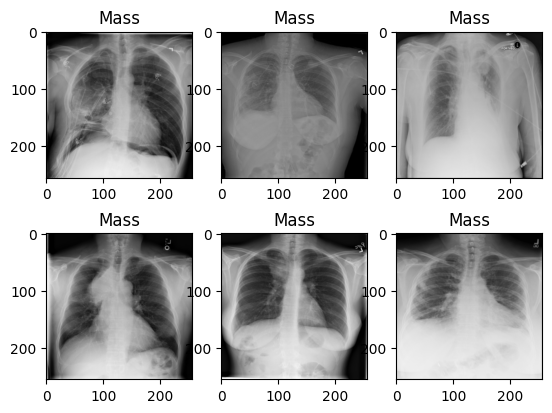

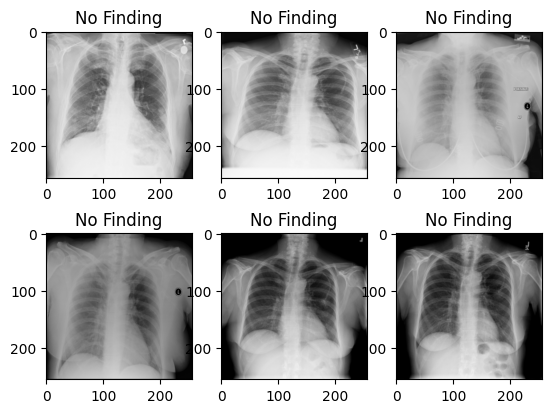

In [16]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2,3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2,3, idx+1)
  plt.title("No Finding")
  plt.imshow(negative_imgs[idx])
plt.show()

In [17]:
pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, 3), weights = 'imagenet', include_top=False)
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)


model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [18]:
# Define our example directories
base_dir = rootdir = "/content/medical-ai/images/"
train_dir= os.path.join(base_dir,finding, 'train')
test_dir = os.path.join(base_dir,finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')

test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

#Data augmentation

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

val_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=2,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=2,
    class_mode='binary'
)

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2

Found 136 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


#Run model

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 20,
    validation_data = test_generator,
    validation_steps = test_steps,
    verbose = 2
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


136/136 - 22s - 158ms/step - acc: 0.5147 - loss: 10.4774 - val_acc: 0.4706 - val_loss: 4.8022
Epoch 2/20
136/136 - 5s - 34ms/step - acc: 0.5956 - loss: 8.3358 - val_acc: 0.5000 - val_loss: 11.7977
Epoch 3/20
136/136 - 5s - 38ms/step - acc: 0.6985 - loss: 2.7722 - val_acc: 0.5882 - val_loss: 2.1522
Epoch 4/20
136/136 - 4s - 32ms/step - acc: 0.6103 - loss: 3.1819 - val_acc: 0.5588 - val_loss: 3.3884
Epoch 5/20
136/136 - 6s - 46ms/step - acc: 0.6912 - loss: 2.3725 - val_acc: 0.5588 - val_loss: 3.4593
Epoch 6/20
136/136 - 9s - 63ms/step - acc: 0.7059 - loss: 2.0127 - val_acc: 0.5294 - val_loss: 0.9120
Epoch 7/20
136/136 - 6s - 45ms/step - acc: 0.6838 - loss: 1.2141 - val_acc: 0.5588 - val_loss: 0.8927
Epoch 8/20
136/136 - 4s - 28ms/step - acc: 0.7353 - loss: 0.5785 - val_acc: 0.6176 - val_loss: 0.9345
Epoch 9/20
136/136 - 4s - 31ms/step - acc: 0.7059 - loss: 0.5987 - val_acc: 0.5588 - val_loss: 0.8667
Epoch 10/20
136/136 - 5s - 39ms/step - acc: 0.7868 - loss: 0.4788 - val_acc: 0.5882 - val

# Plot training and test Accuracy and loss

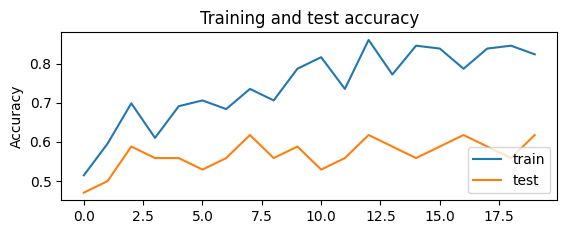

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs,acc, label='train')
plt.plot(epochs,val_acc, label='test')
plt.ylabel('Accuracy')
plt.title("Training and test accuracy")
plt.legend(loc="lower right")


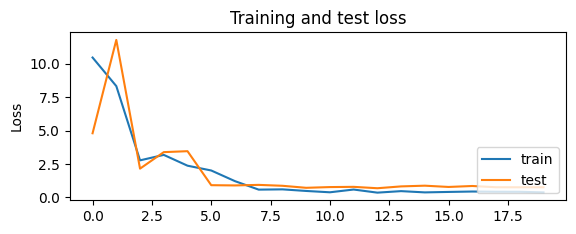

In [23]:
plt.subplot(2,1,1)
plt.plot(epochs,loss, label='train')
plt.plot(epochs,val_loss, label='test')
plt.ylabel('Loss')
plt.title("Training and test loss")
plt.legend(loc="lower right")

# Evaluating performance

In [27]:
# def predict_image(filename):
#   image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
#   image_np = load_image_into_numpy_array(image)
#   exp = np.true_divide(image_np, 255.0)
#   exp = np.stack((exp,)*3, axis=-1)
#   expanded = np.expand_dims(exp, axis=0)
#   return model.predict(expanded)[0][0]

from PIL import Image
import numpy as np

def load_image_into_numpy_array(image):
    return np.array(image)

def predict_image(filename):
    # Open and resize the image
    image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))

    # Convert image to numpy array
    image_np = load_image_into_numpy_array(image)

    # Check if the image has 3 channels, if not, convert it to RGB
    if image_np.shape[-1] != 3:  # If image is grayscale or has no channel info
        image_np = np.stack((image_np,) * 3, axis=-1)

    # Normalize the image data
    exp = image_np / 255.0

    # Expand dimensions to match model input shape (1, 256, 256, 3)
    expanded = np.expand_dims(exp, axis=0)

    # Predict using the model
    return model.predict(expanded)[0][0]


def show_df_row(row):
  image_path = row["filename"]
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  exp = np.stack((exp,)*3, axis=-1)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5: guess= "pos"
  title = "Image: "+row["filename"]+ " Label: "+row["label"]+ " Guess: "+guess+" Score:"+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return


In [28]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])


sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df  = pd.DataFrame(data= sorted_results, columns=["filepath", "filename", "label", "guess", "confidence"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

In [29]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Mass/test/positive/...,00011814_031.jpg,pos,pos,0.975607
1,/content/medical-ai/images/Mass/test/positive/...,00027697_001.jpg,pos,pos,0.970897
2,/content/medical-ai/images/Mass/test/negative/...,00000047_005.jpg,neg,pos,0.928645
3,/content/medical-ai/images/Mass/test/positive/...,00014551_010.jpg,pos,pos,0.917576
4,/content/medical-ai/images/Mass/test/positive/...,00012270_005.jpg,pos,pos,0.866899


Example image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


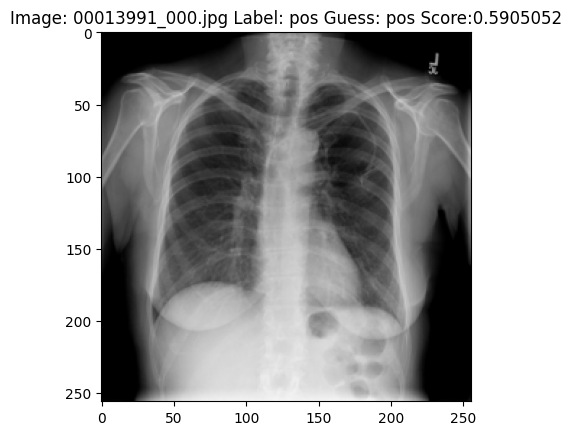

In [33]:
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [34]:
df[::5][['filename','label','guess','confidence']]

,filename,label,guess,confidence
0,00011814_031.jpg,pos,pos,0.975607
5,00015440_000.jpg,pos,pos,0.837448
10,00011925_076.jpg,pos,pos,0.788739
15,00000048_000.jpg,neg,pos,0.687992
20,00000047_002.jpg,neg,pos,0.517291
25,00000047_001.jpg,neg,neg,0.279899
30,00000830_000.jpg,pos,neg,0.140369


# Show histogram

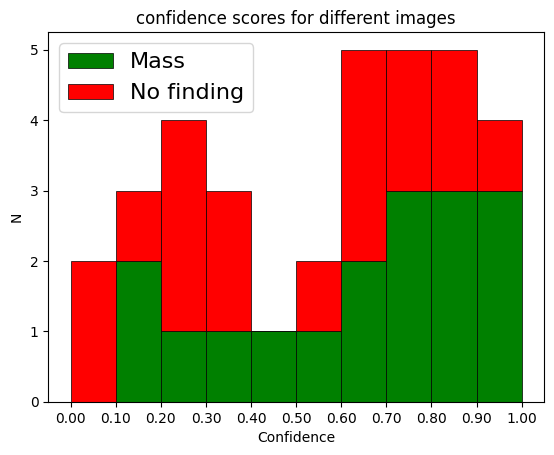

In [38]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label']== 'pos']['confidence']
neg = df.loc[df['label']== 'neg']['confidence']

fig, ax = plt.subplots()
n, bins, patches = plt.hist(
    [pos,neg], np.arange(0.0, 1.1, 0.1).tolist(),
    edgecolor='black', linewidth=0.5, density=False,
    histtype='bar', stacked=True, color=['green', 'red'],
    label=[finding, 'No finding'])

plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('confidence scores for different images')
plt.legend(loc='upper left', fontsize=16)
plt.show()

# CREATE A CUTOFF POINT

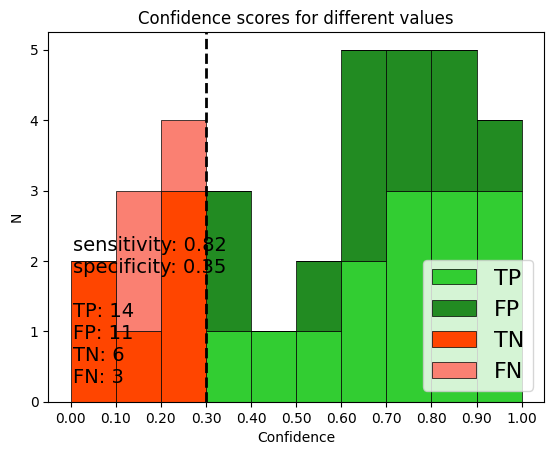

In [41]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]

  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff=0.3)

#ROC CURVE

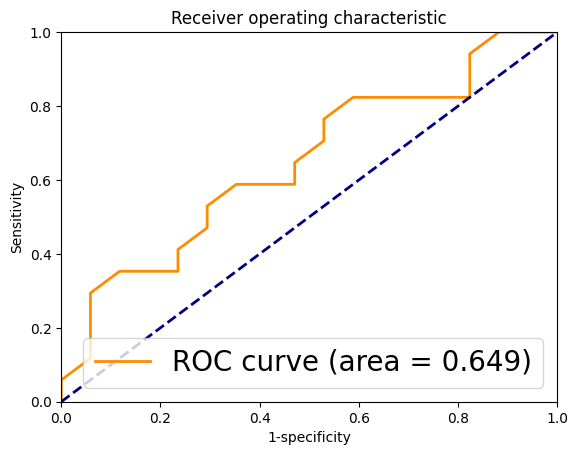

In [42]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

In [47]:
import os

# Create the directory if it doesn't exist
export_dir = '/content/export/'
os.makedirs(export_dir, exist_ok=True)

# Save the model in the directory
model.save(os.path.join(export_dir, 'model_name.h5'))

# Zip the saved model
!zip -r /content/export/model_name.zip /content/export/model_Lungmass.h5


  adding: content/export/model_name.h5 (deflated 44%)
